### Shadow and Gaussian $\Sigma$ matrix comparison

Shadow code from 'sirepo_demo_kb_gsn02' simulation on sirepo.com/shadow

In [1]:
import numpy as np
import shadow_blicon_util as sbu
import transfer_mat_bl as tmb
import Shadow.ShadowTools
import copy
import time

%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

#### Beam parameters

In [2]:
ph_E = 9e3        # photon energy [eV]
sigx_init = 1e-3  # initial horizontal beam size [cm]
sigz_init = 1e-3  # initial vertical beam size [cm]
sigdix_init = 1.1200929999999999e-06  # initial horizontal divergence [rad]
sigdiz_init = 1.1200929999999999e-06  # initial vertical divergence [rad]

#### Calculate coherence

In [3]:
# wavelength [cm]
hc = 1.2398419843320026   # hc quantity [eV micron]
ph_lambda = hc / ph_E * 1e-6 * 1e2

# calculate m squared values horizontal and vertical
m_sq_x = sigx_init * sigdix_init / (ph_lambda / 4 / np.pi)
m_sq_z = sigz_init * sigdiz_init / (ph_lambda / 4 / np.pi)

print('m squared value horizontal: %s' %(m_sq_x)) 
print('m squared value vertical: %s' %(m_sq_z)) 

m squared value horizontal: 1.021739346189318
m squared value vertical: 1.021739346189318


#### Run Shadow simulation with dense Gaussian dist rays

In [4]:
# beam_gsn_init = sbu.shadow_src_beam(n_rays=100000, ran_seed=15829, dist_type=3, sigx=sigx_init, sigz=sigz_init, 
#                                 sigdix=sigdix_init, sigdiz=sigdiz_init, hdiv1 = 0.0, hdiv2 = 0.0, vdiv1 =0.0, 
#                                 vdiv2=0.0, ph_energy = 9e3)

# # create a duplicate of initial beam object to be transformed during propagation
# beam_gsn_init_copy = beam_gsn_init.duplicate()
# beam_gsn_fin = sbu.run_shdw_kb_gsn(beam_gsn_init_copy)

In [5]:
# sbu.shdw_plt(beam_gsn_fin)

#### Calculate error in sigma_x for transfer mat method as function of epsilon

In [6]:
# calculate sigma_x via Shadow propagation

# create initial Shadow beam object
beam_gsn_init = sbu.shadow_src_beam(n_rays=100000, ran_seed=15829, dist_type=3, sigx=sigx_init, sigz=sigz_init, 
                                sigdix=sigdix_init, sigdiz=sigdiz_init, hdiv1 = 0.0, hdiv2 = 0.0, vdiv1 =0.0, 
                                vdiv2=0.0, ph_energy = 9e3)

# create a duplicate of initial beam object to be transformed during propagation
beam_gsn_init_copy = beam_gsn_init.duplicate()
beam_gsn_fin = sbu.run_shdw_kb_gsn(beam_gsn_init_copy)

# calculate sigma matrix from propagated Shadow ray distribution
shdw_sigma_mat_fin = sbu.rays_sigma_mat(beam_gsn_fin)

sigma_x_shdw = np.sqrt(shdw_sigma_mat_fin[0, 0])

printmd('Shadow calculation, $$\sigma_x$$ = %s $$\mu m$$' %(sigma_x_shdw*1e4))

 Generated         5000  rays out of       100000
                  10000
                  15000
                  20000
                  25000
                  30000
                  35000
                  40000
                  45000
                  50000
                  55000
                  60000
                  65000
                  70000
                  75000
                  80000
                  85000
                  90000
                  95000
                 100000
 Exit from SOURCE
 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OPTAXIS
 Exit from OPTAXIS
 Call to MSETUP
 Exit from MSETUP
 Call to RESTART
 Exit from RESTART
 Call to MIRROR
 Exit from MIRROR
 Call to IMAGE
 Exit from IMAGE
 Call to DEALLOC
 Exit from DEALLOC
 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OPTAXIS
 Exit from OPTAXIS
 Call to MSETUP
 Exit from MSETU

Shadow calculation, $$\sigma_x$$ = 3.146682305483299 $$\mu m$$

In [7]:
# Sigma matrix propagation via transfer matrix method with scan over epsilon values

n_epsilon = 50                                                 # no. of yaw parameters to scan 
epsilon_min = -13                                              # min value of yaw [deg]
epsilon_max = -4                                               # max value of yaw [deg]
epsilon_vals = np.logspace(epsilon_min, epsilon_max, n_epsilon)             # array of yaw vals [deg]

printmd('%s scans in range of epsilon values: {1E%.1f, 1E%.1f}' %(n_epsilon, epsilon_min, epsilon_max))


sigmax_error_vals = []
sigma_sum_error_vals = []

# create initial sigma matrix
# res = np.matrix([
#         [sigx_init ** 2, 0, 0, 0],
#         [0, sigdix_init ** 2, 0, 0],
#         [0, 0, sigz_init ** 2, 0],
#         [0, 0, 0, sigdiz_init ** 2],
#     ])

# create initial sigma matrix
res = sbu.rays_sigma_mat(beam_gsn_init)

50 scans in range of epsilon values: {1E-13.0, 1E-4.0}

In [8]:
t0 = time.time()
for j in range(len(epsilon_vals)):
    # printmd('***')
    # printmd(r'roll misalignment: %s mrad' %(el_ro_vals[j]*1e3))
    
    print('this statement should print during each iteration of the for loop')
    
    # calculate sigma_x from transfer mat propagation
    
    # create initial set of 4 offset rays and 1 central ray
    beam_tmat_init = tmb.create_mat_rays(epsilon_vals[j])
    
    # pass initial rays through beamline
    beam_tmat_fin = sbu.run_shdw_kb_gsn(beam_tmat_init)
    
    # calculate transfer matrix from final propagated rays
    tmat, x_prop_cen, xp_prop_cen, z_prop_cen, zp_prop_cen = tmb.tmat_calc(beam_tmat_fin, epsilon_vals[j])
    
    # propagate sigma matrix with transfer matrix
    res_prop = np.matmul(np.matmul(tmat, res), tmat.T)
    
    # calculate sigma_x from res_prop
    sigma_x_tmat_method = np.sqrt(res_prop[0, 0])
    
    # calculate error between Shadow and transfer mat methods and append to array
    sigmax_error_vals.append((sigma_x_shdw - sigma_x_tmat_method) / sigma_x_shdw)
    
    # calculate sqrt sum of the squares Between Shadow and transfer mat sigma matrices 
    sigma_sum_error_vals.append(np.sqrt(np.sum(np.square(shdw_sigma_mat_fin - res_prop))))
    
# t1 = time.time()
# printmd('***')
# printmd("simulation time: %4.3f seconds" % ((t1 - t0)))    

# print(sigmax_error_vals)

this statement should print during each iteration of the for loop
 Exit from SOURCE
 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OPTAXIS
 Exit from OPTAXIS
 Call to MSETUP
 Exit from MSETUP
 Call to RESTART
 Exit from RESTART
 Call to MIRROR
 Exit from MIRROR
 Call to IMAGE
 Exit from IMAGE
 Call to DEALLOC
 Exit from DEALLOC
 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OPTAXIS
 Exit from OPTAXIS
 Call to MSETUP
 Exit from MSETUP
 Call to RESTART
 Exit from RESTART
 Call to MIRROR
 MIRROR1: Warning: Empty element (no mirr.xx file)
 Call to IMAGE
 Exit from IMAGE
 Call to DEALLOC
 Exit from DEALLOC
 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OPTAXIS
 Exit from OPTAXIS
 Call to MSETUP
 Exit from MSETUP
 Call to RESTART
 Exit from RESTART
 Call to MIRROR
 Exit from MIRROR
 Call to IMAGE
 Exit from I

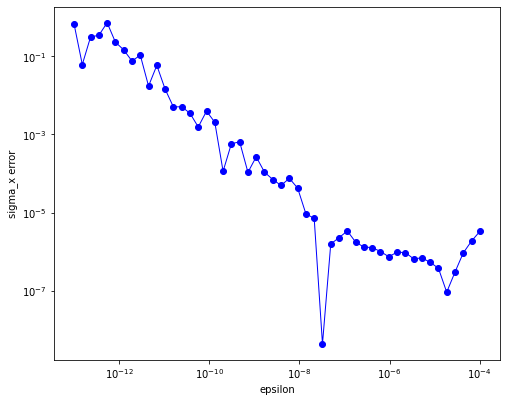

In [9]:
# plot sigma_x error vs epsilon
fig = plt.figure(figsize=(8,6.5))
ax = fig.gca()
ax.plot(epsilon_vals, np.abs(sigmax_error_vals), 'b-o', lw = 1)
plt.xscale('log')
plt.yscale('log')
# ax.vlines(t_vals, 0, T_center, linestyle="dashed")
# ax.axvline(x=t_off, color='k', ls='--')
ax.set_xlabel(r'epsilon')
ax.set_ylabel(r'sigma_x error')
# ax.legend()
fig.show()

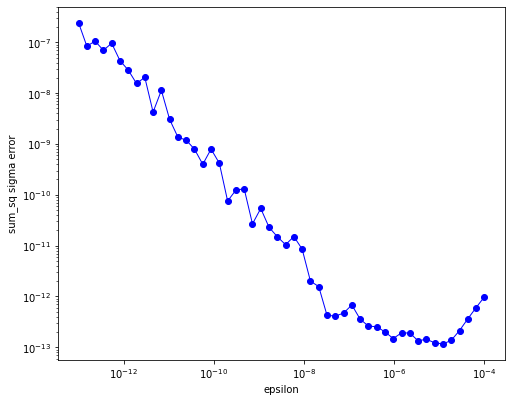

In [10]:
# plot sigma_x error vs epsilon
fig = plt.figure(figsize=(8,6.5))
ax = fig.gca()
ax.plot(epsilon_vals, sigma_sum_error_vals, 'b-o', lw = 1)
plt.xscale('log')
plt.yscale('log')
# ax.vlines(t_vals, 0, T_center, linestyle="dashed")
# ax.axvline(x=t_off, color='k', ls='--')
ax.set_xlabel(r'epsilon')
ax.set_ylabel(r'sum_sq sigma error')
# ax.legend()
fig.show()

In [ ]:
print(res)

In [ ]:
print(np.sqrt(np.sum(np.square(res))))

In [ ]:
epsilon = 1e-6    # beam offest parameter

# create initial set of 4 offset rays and 1 central ray
beam_tmat_init = tmb.create_mat_rays(epsilon)

# pass initial rays through beamline
beam_tmat_fin = sbu.run_shdw_kb_gsn(beam_tmat_init)

# calculate transfer matrix from final propagated rays
tmat, x_prop_cen, xp_prop_cen, z_prop_cen, zp_prop_cen = tmb.tmat_calc(beam_tmat_fin, epsilon)

print('transfer matrix:', tmat)

In [ ]:
# sbu.shdw_plt(beam_tmat_fin)

##### Check symplecticity
$$T^T J T = J$$

In [ ]:
jmat = np.matrix([
    [0, 1, 0, 0],
    [-1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, -1, 0],
])

jmat_calc = np.matmul(np.matmul(tmat.T, jmat), tmat)

print('tmat:', tmat)
print('jmat:', jmat)
print('jmat_calc:', np.round(jmat_calc, 4))

#### Compare Shadow vs Sigma matrix rms size

##### Calculate RMS size for Shadow Gaussian dist propagation

In [ ]:
sigmax = sbu.rays_sigma(beam_gsn_fin, 0, 0)
# sigdix = sbu.rays_sigma(rays, 3)
sigmaz = sbu.rays_sigma(beam_gsn_fin, 2, 2)
# sigdiz = sbu.rays_sigma(rays, 5)
print('sigmax: %s [um], sigmaz: %s [um]' %(sigmax*1e4, sigmaz*1e4))

##### Propagate Sigma matrix with transfer matrix and calculate rms size
$$T\Sigma T^T$$

In [ ]:
# create initial sigma matrix
res = np.matrix([
        [sigx_init ** 2, 0, 0, 0],
        [0, sigdix_init ** 2, 0, 0],
        [0, 0, sigz_init ** 2, 0],
        [0, 0, 0, sigdiz_init ** 2],
    ])

In [ ]:
# propagate sigma matrix with transfer matrix
res_prop = np.matmul(np.matmul(tmat, res), tmat.T)

In [ ]:
print('initial sigma matrix: \n', res)
print('propagated sigma matrix: \n', res_prop)

##### Shadow and Sigma matrix rms sizes

In [ ]:
printmd('Sigma matrix method: sigmax: %.4s [$\mu m$], sigmaz: %.4s [$\mu m$]' %(sigmax*1e4, sigmaz*1e4))
printmd(r'Shadow: sigmax: %.4s [$\mu m$], sigmaz: %.4s [$\mu m$]' %(np.sqrt(res_prop[0,0])*1e4, np.sqrt(res_prop[2,2])*1e4))

#### Calculate full Sigma matrix from Shadow distribution via sbu.rays_sigma_mat()

In [ ]:
shdw_sigma_mat_init = sbu.rays_sigma_mat(beam_gsn_init)
print('Initial Sigma matrix from Shadow distribution: \n', shdw_sigma_mat_init)

shdw_sigma_mat_fin = sbu.rays_sigma_mat(beam_gsn_fin)
print('Propagated Sigma matrix from Shadow distribution: \n', shdw_sigma_mat_fin)

#### Compare Sigma matrices from Shadow and transfer mat methods

In [ ]:
print(shdw_sigma_mat_fin)
print(res_prop)

In [ ]:
(shdw_sigma_mat_fin - res_prop) / np.max(shdw_sigma_mat_fin)

In [ ]:
# Shadow.ShadowTools.plotxy(beam, 1, 3, nbins=100, nolost=1)